## Regret Analysis of OFL - \<Performance Experiments\>

### 1. Environment Setting

In [26]:
import  torch
import  numpy as np
import  matplotlib.pyplot as plt
from    keras import datasets
import  import_ipynb

from RegretBound import opt_param
from data import MNIST_data, Air_data, Syn_data
from model import OFL_Model
from utils import sigma_diff

K = 1000        # Number of clients
#D = 34826       # number of parameters
D = 4289
P = 0.1        # Com. overhead reduction rate from FedOGD
L = 4           # Local training time (Batch Size)

s, _, b, p = opt_param(P, D, show_result=False)
p2 = p * L
print(s, b, p, p2)

17 139 0.5150752711045926 2.0603010844183705


In [23]:
import tensorflow as tf
import keras
from keras import layers, models
from data import MNIST_data, Air_data

x_train, y_train, input_size = Air_data()
print(input_size)

model = tf.keras.Sequential([
            tf.keras.Input(shape=(input_size, 1)),
            layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01), bias_initializer=tf.keras.initializers.Zeros()),
            layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01), bias_initializer=tf.keras.initializers.Zeros()),
            layers.Dense(1)
        ])



5


In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 5, 32)             64        
_________________________________________________________________
dense_18 (Dense)             (None, 5, 64)             2112      
_________________________________________________________________
dense_19 (Dense)             (None, 5, 32)             2080      
_________________________________________________________________
dense_20 (Dense)             (None, 5, 1)              33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


### 2. Experiment Setting

In [25]:
#MNIST
# x_train, y_train, input_size = MNIST_data(iid=True, shuffle=False)
# task = 'clf'

#Air
x_train, y_train, input_size = Air_data()
task = 'reg'

#Synthetic data
# x_train, y_train = pull_Syn_data('Syn', 0)
# task = ''

Model_list = []

Model_list.append(OFL_Model('FedOGD', task, K, [False, 0, 0], 1, 1, input_size))
Model_list.append(OFL_Model('OFedAvg', task, K, [False, 0, 0], P, 1, input_size))
Model_list.append(OFL_Model('FedOMD', task, K, [False, 0, 0], 1, 10, input_size))
Model_list.append(OFL_Model('OFedIQ', task, K, [True, s, b], p, 1, input_size))
# Model_list.append(OFL_Model('OFedIQ(L)', task, K, [True, s, b], p2, L, input_size))



### 3. Training

In [26]:
i_max = len(y_train) // K
iter_max = 13
print(iter_max, i_max)

13 38


In [27]:
for model in Model_list:
    for iter in range(iter_max):
        for i in range(i_max):
            model.train(x_train[K*i : K*(i+1)], y_train[K*i : K*(i+1)], ((i_max * iter) + (i+1)) % model.L)
        print(iter, end =',')

result_list = []
for model in Model_list:
    result_list.append(model.pull_result())

0,1,2,3,4,5,6,7,8,9,10,11,12,0,1,2,3,4,5,6,7,8,9,10,11,12,0,1,2,3,4,5,6,7,8,9,10,11,12,0,1,2,3,4,5,6,7,8,9,10,11,12,

### 3. Save Result

In [28]:
import pickle

code = input("Code: ")

for i, model in enumerate(Model_list):
    name = model.name
    with open(f"./result/{task}_{name}_{code}.pkl","wb") as f:
        pickle.dump(result_list[i], f)

### 4. Plot Result

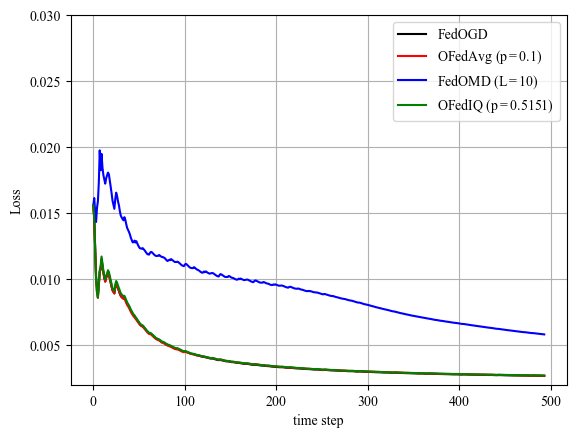

In [4]:
import pickle
import matplotlib.pyplot  as plt

task = 'reg'
code = input('Code:')

with open(f"./result/{task}_FedOGD_{code}.pkl", "rb") as f:
    r1 = pickle.load(f)
with open(f"./result/{task}_OFedAvg_{code}.pkl", "rb") as f:
    r2 = pickle.load(f)
with open(f"./result/{task}_FedOMD_{code}.pkl", "rb") as f:
    r3 = pickle.load(f)
with open(f"./result/{task}_OFedIQ_{code}.pkl", "rb") as f:
    r4 = pickle.load(f)

l1 = list(range(len(r1))) 
l2 = list(range(len(r2)))
l3 = list(range(len(r3)))
l4 = list(range(len(r4)))

plt.plot(l1, r1, 'black', label=r'FedOGD')
plt.plot(l2, r2, 'red', label=r'OFedAvg ($\mathdefault{p=0.1}$)')
plt.plot(l3, r3, 'blue', label=r'FedOMD ($\mathdefault{L=10}$)')
plt.plot(l4, r4, 'green', label=r'OFedIQ ($\mathdefault{p=0.5151}$)')

plt.xlabel('time step')

if task == 'clf':
    plt.ylabel('Accuracy')
elif task == 'reg':
    plt.ylabel('Loss')
    #plt.yscale("log")

plt.ylim([0.002, 0.03])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()

plt.savefig(f'./Figures/{task}_{code}.png', dpi=200, facecolor="white")
plt.show()


### 5. $\sigma_{\rm diff}$

In [16]:
x_train, y_train = MNIST_data()
sigma = sigma_diff(Model_list[0], x_train, y_train, 60)
print(sigma)

12.626342124166777


FedOGD w/ iid data: 7.069452932191554

FedOGD w/ non-iid data: 12.626342124166777

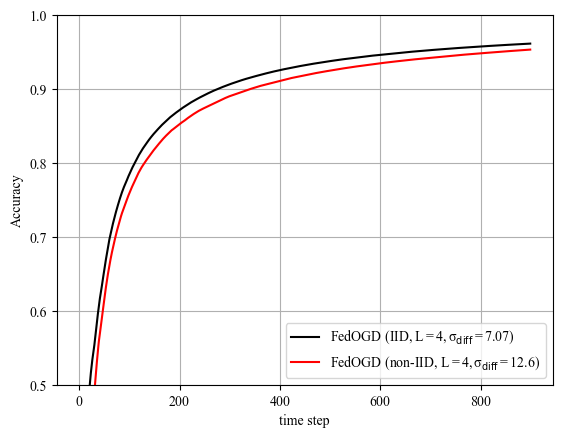

In [73]:

import pickle
import matplotlib.pyplot  as plt

task = 'clf'

with open(f"./result/{task}_FedOGD_sigma_niid.pkl", "rb") as f:
    r1 = pickle.load(f)
with open(f"./result/{task}_FedOGD_sigma_iid.pkl", "rb") as f:
    r2 = pickle.load(f)

l1 = list(range(len(r1))) 
l2 = list(range(len(r2)))

plt.plot(l2, r2, 'black', label=r'FedOGD (IID, $\mathdefault{L=4, \sigma_{\rm diff}=7.07}$)')
plt.plot(l1, r1, 'red', label=r'FedOGD (non-IID, $\mathdefault{L=4, \sigma_{\rm diff}=12.6}$)')

plt.xlabel('time step')

if task == 'clf':
    plt.ylabel('Accuracy')
elif task == 'reg':
    plt.ylabel('Loss')
    plt.yscale("log")

plt.ylim([0.5,1])

plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()

plt.savefig(f'./Figures/Figure3_sigma_diff.png', dpi=200, facecolor="white")
plt.show()